In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# EV Assignment Tool

This script gives an EV-to-charging station assignment tool with M/D/C charging station queueing, The tool outputs the assignment matrix, the access cost matrix, as well as the expected wait time and utilization ratio of charging stations, and average access cost of the origins. It could be used to evaluate current or designed EV charging station configurations. 

The EV assignment is formulated as a capacitated user equilibrium (UE) problem, originally introduced in Beckman et al. (1956), to capture users’ charging station choice. At UE, charging stations used by the EVs from the same origin should have the smallest and the same access cost (travel cost + waiting cost). The capacity if charging station is reflected in the M/D/C queueing model, which assumes users arrive sufficiently randomly while charging time is deterministic (e.g. an empty tank will take half hour to fully recharge in a DCFC). Because there is no closed form expression for an M/D/C model, we make use of an approximation from Barceló et al. (1996). The model is solved using a Method of Successive Averages which guarantees convergence for convex problems like this one (Powell and Sheffi, 1982). 

The following example demonstrate how the tool works.

---

References:

Beckmann, M., McGuire, C. B., & Winsten, C. B. (1956). Studies in the Economics of Transportation (No. 226 pp).

Barceló, F., Casares, V., & Paradells, J. (1996). M/D/C queue with priority: Application to trunked mobile radio systems. Electronics Letters, 32(18), 1644-1644.

Powell, W. B., & Sheffi, Y. (1982). The convergence of equilibrium algorithms with predetermined step sizes. Transportation Science, 16(1), 45-55.

---------------------------------------

# Example

Assume 5 EV parking locations and 3 charging stations. Each parking locations has 1 or more than 1 EV parked there. We are going to use the EV Assignment tool to get a UE assignment of all the EVs to the 3 charging stations.

In [67]:
#Generate parking locations
#x y coordinates between 0 and 10
#number of EVs between 1 and 10
EVLo_x = np.array([1.8,3.0,2.1,8.0,8.4])
EVLo_y = np.array([7.8,6.3,1.8,3.0,1.0])
EVLo_lmda = np.array([3,9,7,1,7])
EVLo_ID = np.array([1,2,3,4,5])
a = {"ID": EVLo_ID,"x":EVLo_x,"y":EVLo_y,"Number of EVs":EVLo_lmda}
EVLo = pd.DataFrame(a)
#Demand Evaluation
demand = sum(EVLo["Number of EVs"].to_numpy())
print('Total number of EVs to be charged per day:',demand)
print("EV Parking Location List:")
EVLo

Total number of EVs to be charged per day: 27
EV Parking Location List:


,ID,x,y,Number of EVs
0,1,1.8,7.8,3
1,2,3.0,6.3,9
2,3,2.1,1.8,7
3,4,8.0,3.0,1
4,5,8.4,1.0,7


In [68]:
#Generate CS locations
#x y coordinates between 0 and 10
#service rate of 1 charger at the charging stations between 1 and 10
#Number of chargers at the charging stations between 1 and 10
CS_x = np.array([3.4,1.7,7.0])
CS_y = np.array([9.9,4.2,7.4])
CS_miu = np.array([2,6,7])
CS_k = np.array([8,3,2])
CS_ID = np.array([1,2,3])
a = {"ID": CS_ID, "x":CS_x,"y":CS_y, "miu":CS_miu, "Number of Chargers":CS_k}
CS = pd.DataFrame(a)
#Supply Evaluation
MIU = CS["miu"].to_numpy()
K = CS["Number of Chargers"].to_numpy()
supply = 0
for i in range(3):
    supply = supply+MIU[i]*K[i]
print('Total service rate:',supply,"veh/day")
print("Charging Station List:")
CS

Total service rate: 48 veh/day
Charging Station List:


,ID,x,y,miu,Number of Chargers
0,1,3.4,9.9,2,8
1,2,1.7,4.2,6,3
2,3,7.0,7.4,7,2


Now we plot the EV parking locations and the charging stations.

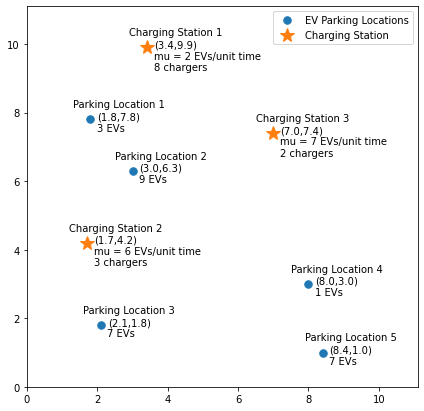

In [69]:
plt.figure(figsize=(7,7))
plt.plot(EVLo.x.to_numpy(),EVLo.y.to_numpy(),'.',markersize = 15, label = 'EV Parking Locations')
plt.plot(CS.x.to_numpy(),CS.y.to_numpy(),'*',markersize = 14, label = 'Charging Station')
plt.legend()
plt.xlim(0,11.1)
plt.ylim(0,11.1)
for i in range(5):
    plt.text(EVLo.x.to_numpy()[i]-0.5,EVLo.y.to_numpy()[i]+0.35,'Parking Location '+str(i+1))
    plt.text(EVLo.x.to_numpy()[i]+0.2,EVLo.y.to_numpy()[i],'('+str(np.round(EVLo.x.to_numpy()[i],1))+','+str(np.round(EVLo.y.to_numpy()[i],1))+')')
for i in range(5):
    plt.text(EVLo.x.to_numpy()[i]+0.18,EVLo.y.to_numpy()[i]-0.33,str(EVLo["Number of EVs"].to_numpy()[i])+" EVs")
for i in range(3):
    plt.text(CS.x.to_numpy()[i]-0.5,CS.y.to_numpy()[i]+0.35,'Charging Station '+str(i+1))
    plt.text(CS.x.to_numpy()[i]+0.2,CS.y.to_numpy()[i],'('+str(np.round(CS.x.to_numpy()[i],1))+','+str(np.round(CS.y.to_numpy()[i],1))+')')
for i in range(3):
    plt.text(CS.x.to_numpy()[i]+0.2,CS.y.to_numpy()[i]-0.33,'mu = '+str(np.round(CS['miu'].to_numpy()[i]))+' EVs/unit time')
    plt.text(CS.x.to_numpy()[i]+0.2,CS.y.to_numpy()[i]-0.66, str(CS["Number of Chargers"].to_numpy()[i])+" chargers")
plt.show()

With coordinates of the parking locations and charging stations, we compute the Euclidean distances as travel distances, and assume a average speed of 20 to compute the travel time matrix.

Note that in real cases, travel distances cannot be approximated by Euclidean distances. To use the tool, the travel time matrix should be pre-computed and formated as stated after the example. 

In [70]:
#travel Time matrix
d = np.zeros((len(EVLo),len(CS)))
for i in range(len(EVLo)):
    for j in range(len(CS)):
        d[i,j] = np.sqrt((EVLo_x[i]-CS_x[j])**2 + (EVLo_y[i]-CS_y[j])**2)
c = d/200 #assume speed = 200
print("Travel Time Matrix:")
print(np.round(c,4))

Travel Time Matrix:
[[0.0132 0.018  0.0261]
 [0.0181 0.0123 0.0207]
 [0.041  0.0122 0.0372]
 [0.0415 0.0321 0.0226]
 [0.051  0.0371 0.0328]]


From the literature, we know that people value charging time and access time differently. So we allow the usrs to assign different weights for access time and charging time. Note that the final output are still in real time units, not weighted. Below are the values we found from the literature (Ge, 2019).

Reference: Ge, Y. (2019). Discrete Choice Modeling of Plug-in Electric Vehicle Use and Charging Behavior Using Stated Preference Data (Doctoral dissertation).

In [71]:
#access time weight
access_time_weight = 6.198
#charging time weight
charging_time_weight = 1

Then we set convergence criterion. When the Euclidean norm of the diffierence between the assignment matrix at this iteration and that at the last iteration is smaller than the convergence criterion (UE is reached to some extent), the algorithm stops and outputs the results. 

In [72]:
#set convergence criterion
e = 10**-4

With large numbers of origins and charging stations, it would take long for the algorithm to converge (sometimes several hours). It might help to keep track of where the algorithm gets. The algorithm is able to print the error (the diffierence between the assignment matrix at this iteration and that at the last iteration), mean access cost of and the number of steady-state charging stations at the current iteration to give a sense of where we are. The number of iterations between 2 consecutive outputs can be set below.

In [73]:
#print setting: print error, mean cost and number of steady-state charging stations every pri iterations
pri = 3000
#if no printing is needed before the final results, set pri as inf
# pri = np.inf

Now we are ready to run the algorithm below.

In [74]:
%%time
################################### MSA ######################################

#initialization
d_ = c.copy() #initialize the travel cost matrix assuming no wait time
X = np.zeros((len(EVLo),len(CS))) #assignment matrix

#iterative Assignment
for n in range(10000000000000):
   
    #re-assign the EVs based on the updated travel cost
    Y = np.zeros((len(EVLo),len(CS)))
    for i in range(len(EVLo)):
        d_min = min(d_[i,:]) 
        J = np.argwhere(d_[i,:] == d_min)[0][0] #Find the closest CS
        Y[i,J] = EVLo["Number of EVs"][i] #Assign the EVs to the closest CS
    if n == 0:
        X = Y
    else:
        X = Y/(n+1) + n*X_/(n+1) # Assign 1/n+1 of the EVs at nth iteartion

    #check convergence
    if n > 0:
        error = abs(np.linalg.norm(X-X_))
        if error < e: # convergence criterion
            print('-------------------- convergence reached --------------------')
            print(" ")
            break
    
    lmda = np.zeros((len(CS))) #initialize arrival rate vector of CS
    rou = np.zeros((len(CS))) #initialize rou vector of CS
    wait_MMK = np.zeros((len(CS))) #initialize M/M/k waiting time vector of CS
    wait_MDK = np.zeros((len(CS))) #initialize M/D/k waiting time vector of CS
    
    #compute waiting time at each CS according to the assignment at this iteration
    steady_index = np.zeros((len(CS)))
    for j in range(len(CS)):
        miu = CS["miu"][j]
        k = CS["Number of Chargers"][j]
        a = EVLo["Number of EVs"].to_numpy()
        lmda[j] = sum(X[:,j]) #compute the arrival rate of each CS
        rou[j] = lmda[j]/(miu*k) #compute the utilization ratio of each CS
        
        if (rou[j] < 1) and (rou[j] > 0): #if the queue at the CS is steady
            steady_index[j] = 1
            #Recursively approximate the M/M/k waiting time
            for m in range(1,k+1):
                if m == 1:
                    alpha = 1
                else:
                    alpha = 1 + miu/lmda[j] * (m-1) * alpha_
                alpha_ = alpha
                wait_MMK[j] = lmda[j] / ( (miu*k-lmda[j])**2 * (alpha + lmda[j]/(miu*k-lmda[j])) ) 
            #Approximate the M/D/K waiting time from M/M/K waiting time          
            wait_MDK[j] = wait_MMK[j]/2 * (1 + (1-rou[j])*(k-1)*(np.sqrt(4+5*k)-2)/(16*rou[j]*k)) + 1/miu
            
        if rou[j] >= 1: #if the queue at the CS is unsteady
            steady_index[j] = 0
            wait_MDK[j] = lmda[j]/(2*miu*k) + 1/miu
            
        if rou[j] == 0: #if no EV is assigned to the CS
            steady_index[j] = 1
            wait_MDK[j] = 0
            
    #add waiting time to travel cost to get new travel cost       
    for i in range(len(EVLo)):
        for j in range(len(CS)):
            d_[i,j] = access_time_weight*c[i,j] + charging_time_weight*wait_MDK[j]
            
    X_ = X #save the result of this iteration
    
    if n % pri == 0 and n>0:
        print('Iteration ',n)
        print("error = ", error)
        print("mean cost:", np.mean(d_))
        print("number of steady-state CS:", sum(steady_index))
        print('---------------------------------------')


#-------------------------------------------------------------------------

#compute the cost of final assignment (travel time + queuing time)
d_final = np.zeros((len(EVLo),len(CS)))
for j in range(len(CS)):
    miu = CS["miu"][j]
    k = CS["Number of Chargers"][j]
    a = EVLo["Number of EVs"].to_numpy()
    lmda[j] = sum(X[:,j]) #compute the arrival rate of each CS
    rou[j] = lmda[j]/(miu*k) #compute the utilization ratio of each CS

    if (rou[j] < 1) and (rou[j] > 0): #if the queue at the CS is steady
        #Recursively approximate the M/M/k waiting time
        for m in range(1,k+1):
            if m == 1:
                alpha = 1
            else:
                alpha = 1 + miu/lmda[j] * (m-1) * alpha_
            alpha_ = alpha
            wait_MMK[j] = lmda[j] / ( (miu*k-lmda[j])**2 * (alpha + lmda[j]/(miu*k-lmda[j])) ) 
        #Approximate the M/D/K waiting time from M/M/K waiting time          
        wait_MDK[j] = wait_MMK[j]/2 * (1 + (1-rou[j])*(k-1)*(np.sqrt(4+5*k)-2)/(16*rou[j]*k)) + 1/miu

    if rou[j] >= 1: #if the queue at the CS is unsteady
        wait_MDK[j] = lmda[j]/(2*miu*k) + 1/miu

    if rou[j] == 0: #if no EV is assigned to the CS
        wait_MDK[j] = 0

#add waiting time to travel cost to get new travel cost       
for i in range(len(EVLo)):
    for j in range(len(CS)):
        d_final[i,j] = c[i,j] + wait_MDK[j] #Access time + Charging time Matrix
        

#----------------------------------------------------------------------------------------------------------
os.mkdir('Results_example')
np.savetxt('Results_example/Assignment Matrix_example.csv', X, delimiter=",")
np.savetxt('Results_example/Access Time + Charging Time Matrix_example.csv', d_final, delimiter=",")

#Charging Time Matrix
char = 1/CS['miu'].to_numpy()
t_char = np.array(list(char)*len(EVLo)).reshape(len(EVLo),len(CS))
np.savetxt('Results_example/Charging Time Matrix_example.csv', t_char, delimiter=",")

#Access Time Matrix
t_access = d_final - t_char
np.savetxt('Results_example/Access Time Matrix_example.csv', t_access, delimiter=",")

# Compute the EV Location Table
acc_char = np.dot(X,d_final.T).diagonal() 
EVLo_avg_acc_char = np.zeros((len(EVLo)))
for i in range(len(EVLo)):
    EVLo_avg_acc_char[i] = acc_char[i]/a[i]
access = np.dot(X,t_access.T).diagonal() 
a = EVLo["Number of EVs"].to_numpy()
EVLo_avg_access = np.zeros((len(EVLo)))
for i in range(len(EVLo)):
    EVLo_avg_access[i] = access[i]/a[i]   
EVLo_avg_char = EVLo_avg_acc_char-EVLo_avg_access
ID = EVLo.ID.to_numpy()    
b = {"ID":ID, 
     "Avg Access Time":EVLo_avg_access, 
     "Avg Charging Time":EVLo_avg_char,
     "Avg Access+Charging Time":EVLo_avg_acc_char}
EVLo_avg = pd.DataFrame(b)
EVLo_avg.to_csv("Results_example/EV Parking Location Table_example.csv")

# Compute the Charging Station Table
CS_ID = CS['ID'].to_numpy()
que = wait_MDK-char
a = {"CS_ID":CS_ID,
     "Utilization Ratio":rou,
     "Queue Delay":que,
     "Charging Time":char,
     "Queue Delay+Charging Time":wait_MDK}
CS_final = pd.DataFrame(data = a)
CS_final.to_csv("Results_example/Charging Station Table_example.csv")

# System total access time
sys_access = np.sum(access)
# System total access time + charging time
sys_acc_char = np.sum(acc_char)

num_EV = np.sum(EVLo['Number of EVs'].to_numpy())

# Average access time
avg_access = sys_access/num_EV
# Averagel access time + charging time
avg_acc_char = sys_acc_char/num_EV
        
# output the results
print('--- Final Results ---')
print("number of steady-state charging stations:", sum(steady_index))
print("number of iterations: ",n)
print(" ")
print("Assignment:")
print(np.round(X,2))
print(" ")
print("Access time:")
print(np.round(t_access,2))
print(" ")
print("Charging time:")
print(np.round(t_char,2))
print(" ")
print("Access + Charging time:")
print(np.round(d_final,2))
print(" ")
print('Charging stations at UE:')
print(CS_final)
print(" ")
print('EV Locations:')
print(EVLo_avg)
print(" ")
print('System Total Access Time:', np.round(sys_access,3))
print('System Total Access + Charging Time:', np.round(sys_acc_char,3))
print('Average Access Time for 1 EV:', np.round(avg_access,3))
print('Average Access + Charging Time for 1 EV:', np.round(avg_acc_char,3))
print(" ")

Iteration  3000
error =  0.0040044445747876925
mean cost: 0.5429259193439134
number of steady-state CS: 3.0
---------------------------------------
Iteration  6000
error =  0.00010114591913516266
mean cost: 0.5429532072358173
number of steady-state CS: 3.0
---------------------------------------
-------------------- convergence reached --------------------
 
--- Final Results ---
number of steady-state charging stations: 3.0
number of iterations:  6055
 
Assignment:
[[0.   0.08 2.92]
 [0.   8.58 0.42]
 [0.   7.   0.  ]
 [0.   0.   1.  ]
 [0.   0.   7.  ]]
 
Access time:
[[0.01 0.18 0.16]
 [0.02 0.18 0.16]
 [0.04 0.18 0.18]
 [0.04 0.2  0.16]
 [0.05 0.2  0.17]]
 
Charging time:
[[0.5  0.17 0.14]
 [0.5  0.17 0.14]
 [0.5  0.17 0.14]
 [0.5  0.17 0.14]
 [0.5  0.17 0.14]]
 
Access + Charging time:
[[0.51 0.35 0.31]
 [0.52 0.34 0.3 ]
 [0.54 0.34 0.32]
 [0.54 0.36 0.3 ]
 [0.55 0.37 0.31]]
 
Charging stations at UE:
   CS_ID  Utilization Ratio  Queue Delay  Charging Time  \
0      1           0.

The tool outputs the assignment matrix, the access costs matrix (Travel and wait time matrix), number of steady-state charging stations, number of iterations when converge, table of charging station utilization ratio and expected wait time at UE, and average access time of origins at UE. In the example, these results are printed out. While in the following tool, the outputs are saved as CSV files.

Note: Please make sure to check the number of steady-state charging stations when converge. If the number of steady-state charging stations is less than the total number of charging stations, this tool might not be very accurate.

--------------------------------------

# To use this Tool:

Please save the EV location list, charging station list and the travel cost matrix as csv files in the same folder as this script, then fill in the file names in the following cell correspondingly.

## 1. Read in the EV location csv file
    Parameter "EVLo": information of the EV demand and locations. There are 2 columns in the table:
    "ID" : 1,2,3,4,... (int64)
    "Number of EVs" : the number of EVs to be charged per unit time at that location (int64)
    
    Please name the columns exactly as required.

In [ ]:
# read the EV location list
EVLo = pd.read_csv('NYC_total_charging_demand.csv') #Please change the file name here if you are using other file

## 2. Read in the Charging Station csv file
    Parameter "CS": information of the charging station and their service capacities. There are 3 columns in the table:
    "ID" : 1,2,3,4,... (int64)
    "miu": service rate (number of EVs charged/unit time) of one charger at this charging station (int64)
    "Number of Chargers" : the number of chargers at this charging station (int64)
    
    Note: Within each charging station, all the chargers are of the same type (Level 2 or DC Fast).If some charging stations in
        
    Please name the columns exactly as required.

In [ ]:
#read charging station list
CS = pd.read_csv('NYC_public_charging_stations_nonTesla.csv') #Please change the file name here if you are using other file

## 3. Read in the OD cost Matrix csv file
    Parameter "c": the travel distance matrix.
    Note:
    1) The sequence of the rows should correspond to the sequence of the EV Locations in the EV location csv file, and the sequence of the columns should correspond to the sequence of the charging station csv file (float64)
    2) No heading and index in the csv file

In [ ]:
#read the OD cost matrix file
c = np.genfromtxt('NYC_Zone_public_charging_station_distance_matrix.csv', delimiter=",") #Please change the file name here if you are using other file

## 4. Set Average Travel Speed
    Parameter "v": average travel speed of the EV's.
    Note: Unit of the speed should be: unit of distance for OD cost/unit of time for service rate and number of EVs to be charged

In [ ]:
#set travel speed
v = 
c = c/v

## 5. Set Weights for Access Time and Charging Time
    Parameter "access_time_weight":  weight of access time. Recommended value is 6.198.
    Parameter "charging_time_weight":  weight of charging time. Recommended value is 1.
    For the recommended values, please refer to Ge 2019.
    
    Reference: Ge, Y. (2019). Discrete Choice Modeling of Plug-in Electric Vehicle Use and Charging Behavior Using Stated Preference Data (Doctoral dissertation).

In [55]:
#access time weight
access_time_weight = 6.198
#charging time weight
charging_time_weight = 1

## 6. Set Convergence Criteria
    Parameter "e":  If the Euclidean norm of the difference between the assignment matrix of this iteration and the last iteration is less than e, the algorithm stops and outputs the results. 

In [ ]:
#set convergence criterion
e = 10**-3 #this is the value that we recommend for city-scale runs

## 7. Set Printing
    Parameter "pri": print error, mean cost and number of steady-state charging stations every pri iterations. If no printing is needed before the final results, set pri as inf (pri = np.inf)

In [ ]:
#set printing
pri = 

## 8. Run the algorithm
    After the algorithm converges with the convergence criterion that you set, please check if all the charging stations are at steady state. 
    The 6 output files are saved in a folder named "Results" where this script is saved. Please make sure that there's no folder named "Results" at the directiry where the script and input files are saved. The output files include:
    
     - Assignment Matrix.csv
     - Access Time Matrix.csv
     - Charging Time Matrix.csv
     - Access + Charging Time Matrix.csv
     - Charging Station Table.csv
         - Columns:“Utilization Ratio”, 
                   “Expected Queue Delay”, 
                   “Charging Time”, 
                   “Expected Queue Delay + Charging Time”
     - EV Parking Location Table.csv
         - Columns:“Average Access Time”, 
                   “Average Charging Time”, 
                   “Average Access +Charging Time”
    
    The following results are directly printed:
     - System Total Access Time
     - System Total Access Time + Charging Time
     - Average Access Time for one EV
     - Average Access Time + Charging Time
     - Number of steady-state (utilization ratio ≤ 1) charging stations at convergence 
       (should be equal to the total number of charging stations to get accurate results)
     - Number of iterations until convergence
     - Run time of the algorithm (wall time)

Run the algorithm below:

In [ ]:
%%time
################################### MSA ######################################

#initialization
d_ = c.copy() #initialize the travel cost matrix assuming no wait time
X = np.zeros((len(EVLo),len(CS))) #assignment matrix

#iterative Assignment
for n in range(10000000000000):
   
    #re-assign the EVs based on the updated travel cost
    Y = np.zeros((len(EVLo),len(CS)))
    for i in range(len(EVLo)):
        d_min = min(d_[i,:]) 
        J = np.argwhere(d_[i,:] == d_min)[0][0] #Find the closest CS
        Y[i,J] = EVLo["Number of EVs"][i] #Assign the EVs to the closest CS
    if n == 0:
        X = Y
    else:
        X = Y/(n+1) + n*X_/(n+1) # Assign 1/n+1 of the EVs at nth iteartion

    #check convergence
    if n > 0:
        error = abs(np.linalg.norm(X-X_))
        if error < e: # convergence criterion
            print('-------------------- convergence reached --------------------')
            print(" ")
            break
    
    lmda = np.zeros((len(CS))) #initialize arrival rate vector of CS
    rou = np.zeros((len(CS))) #initialize rou vector of CS
    wait_MMK = np.zeros((len(CS))) #initialize M/M/k waiting time vector of CS
    wait_MDK = np.zeros((len(CS))) #initialize M/D/k waiting time vector of CS
    
    #compute waiting time at each CS according to the assignment at this iteration
    steady_index = np.zeros((len(CS)))
    for j in range(len(CS)):
        miu = CS["miu"][j]
        k = CS["Number of Chargers"][j]
        a = EVLo["Number of EVs"].to_numpy()
        lmda[j] = sum(X[:,j]) #compute the arrival rate of each CS
        rou[j] = lmda[j]/(miu*k) #compute the utilization ratio of each CS
        
        if (rou[j] < 1) and (rou[j] > 0): #if the queue at the CS is steady
            steady_index[j] = 1
            #Recursively approximate the M/M/k waiting time
            for m in range(1,k+1):
                if m == 1:
                    alpha = 1
                else:
                    alpha = 1 + miu/lmda[j] * (m-1) * alpha_
                alpha_ = alpha
                wait_MMK[j] = lmda[j] / ( (miu*k-lmda[j])**2 * (alpha + lmda[j]/(miu*k-lmda[j])) ) 
            #Approximate the M/D/K waiting time from M/M/K waiting time          
            wait_MDK[j] = wait_MMK[j]/2 * (1 + (1-rou[j])*(k-1)*(np.sqrt(4+5*k)-2)/(16*rou[j]*k)) + 1/miu
            
        if rou[j] >= 1: #if the queue at the CS is unsteady
            steady_index[j] = 0
            wait_MDK[j] = lmda[j]/(2*miu*k) + 1/miu
            
        if rou[j] == 0: #if no EV is assigned to the CS
            steady_index[j] = 1
            wait_MDK[j] = 0
            
    #add waiting time to travel cost to get new travel cost       
    for i in range(len(EVLo)):
        for j in range(len(CS)):
            d_[i,j] = access_time_weight*c[i,j] + charging_time_weight*wait_MDK[j]
            
    X_ = X #save the result of this iteration
    
    if n % pri == 0 and n>0:
        print('Iteration ',n)
        print("error = ", error)
        print("mean cost:", np.mean(d_))
        print("number of steady-state CS:", sum(steady_index))
        print('---------------------------------------')


#-------------------------------------------------------------------------

#compute the cost of final assignment (travel time + queuing time)
d_final = np.zeros((len(EVLo),len(CS)))
for j in range(len(CS)):
    miu = CS["miu"][j]
    k = CS["Number of Chargers"][j]
    a = EVLo["Number of EVs"].to_numpy()
    lmda[j] = sum(X[:,j]) #compute the arrival rate of each CS
    rou[j] = lmda[j]/(miu*k) #compute the utilization ratio of each CS

    if (rou[j] < 1) and (rou[j] > 0): #if the queue at the CS is steady
        #Recursively approximate the M/M/k waiting time
        for m in range(1,k+1):
            if m == 1:
                alpha = 1
            else:
                alpha = 1 + miu/lmda[j] * (m-1) * alpha_
            alpha_ = alpha
            wait_MMK[j] = lmda[j] / ( (miu*k-lmda[j])**2 * (alpha + lmda[j]/(miu*k-lmda[j])) ) 
        #Approximate the M/D/K waiting time from M/M/K waiting time          
        wait_MDK[j] = wait_MMK[j]/2 * (1 + (1-rou[j])*(k-1)*(np.sqrt(4+5*k)-2)/(16*rou[j]*k)) + 1/miu

    if rou[j] >= 1: #if the queue at the CS is unsteady
        wait_MDK[j] = lmda[j]/(2*miu*k) + 1/miu

    if rou[j] == 0: #if no EV is assigned to the CS
        wait_MDK[j] = 0

#add waiting time to travel cost to get new travel cost       
for i in range(len(EVLo)):
    for j in range(len(CS)):
        d_final[i,j] = c[i,j] + wait_MDK[j] #Access time + Charging time Matrix
        

#----------------------------------------------------------------------------------------------------------
os.mkdir('Results')
np.savetxt('Results/Assignment Matrix.csv', X, delimiter=",")
np.savetxt('Results/Access Time + Charging Time Matrix.csv', d_final, delimiter=",")

#Charging Time Matrix
char = 1/CS['miu'].to_numpy()
t_char = np.array(list(char)*len(EVLo)).reshape(len(EVLo),len(CS))
np.savetxt('Results/Charging Time Matrix.csv', t_char, delimiter=",")

#Access Time Matrix
t_access = d_final - t_char
np.savetxt('Results/Access Time Matrix.csv', t_access, delimiter=",")

# Compute the EV Location Table
acc_char = np.dot(X,d_final.T).diagonal() 
EVLo_avg_acc_char = np.zeros((len(EVLo)))
for i in range(len(EVLo)):
    EVLo_avg_acc_char[i] = acc_char[i]/a[i]
access = np.dot(X,t_access.T).diagonal() 
a = EVLo["Number of EVs"].to_numpy()
EVLo_avg_access = np.zeros((len(EVLo)))
for i in range(len(EVLo)):
    EVLo_avg_access[i] = access[i]/a[i]   
EVLo_avg_char = EVLo_avg_acc_char-EVLo_avg_access
ID = EVLo.ID.to_numpy()    
b = {"ID":ID, 
     "Avg Access Time":EVLo_avg_access, 
     "Avg Charging Time":EVLo_avg_char,
     "Avg Access+Charging Time":EVLo_avg_acc_char}
EVLo_avg = pd.DataFrame(b)
EVLo_avg.to_csv("Results/EV Parking Location Table.csv")

# Compute the Charging Station Table
CS_ID = CS['ID'].to_numpy()
que = wait_MDK-char
a = {"CS_ID":CS_ID,
     "Utilization Ratio":rou,
     "Queue Delay":que,
     "Charging Time":char,
     "Queue Delay+Charging Time":wait_MDK}
CS_final = pd.DataFrame(data = a)
CS_final.to_csv("Results/Charging Station Table.csv")

# System total access time
sys_access = np.sum(access)
# System total access time + charging time
sys_acc_char = np.sum(acc_char)

num_EV = np.sum(EVLo['Number of EVs'].to_numpy())

# Average access time
avg_access = sys_access/num_EV
# Averagel access time + charging time
avg_acc_char = sys_acc_char/num_EV
        
# output the results
print('--- Final Results ---')
print("Assignment Matrix, Access Time Matrix, Charging Time Matrix, Access Time + Charging Time Matrix, EV Parking Location Table and Charging Station Table are saved to the folder.")
print(" ")
print("number of steady-state charging stations:", sum(steady_index))
print("number of iterations: ",n)
print(" ")
print('System Total Access Time:', np.round(sys_access,3))
print('System Total Access + Charging Time:', np.round(sys_acc_char,3))
print('Average Access Time for 1 EV:', np.round(avg_access,3))
print('Average Access + Charging Time for 1 EV:', np.round(avg_acc_char,3))
print(" ")

Github link:
https://github.com/BUILTNYU/EV_Charging_Station_Access_Equlibrium_Model

Our paper on this:
https://www.researchgate.net/publication/349234204_An_electric_vehicle_charging_station_access_equilibrium_model_with_MDC_queueing


Thank you!

--

Bingqing (Chloe) Liu

Ph.D Candidate in Transportation Planning and Engineering

C2SMART

New York University Tandon School of Engineering

bl2453@nyu.edu